In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n
    
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
    
    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore

**공통 초기설정: 데이터 로드, 리밸런싱 날짜**  

In [2]:
closeDataSet = pd.read_csv("./정적자산배분데이터.csv", index_col=0, parse_dates=True)
closeDataSet = closeDataSet.loc['2010-12-31':]

In [3]:
rebalDate = getRebalancingDate(closeDataSet)

**영구 포트폴리오**

In [4]:
# 데이터 준비
perCol = ['VTI', "TLT", "SHY", "GLD"]
perData = closeDataSet[perCol]

In [5]:
perWeight = [0.25, 0.25, 0.25, 0.25]
perWeightDf = pd.DataFrame([perWeight] * len(rebalDate))
perWeightDf.index = rebalDate
perWeightDf.columns = perCol

**황금나비 포트폴리오**

In [6]:
# 데이터 준비
flyCol = ['VTI', "VBR", "TLT", "SHY", "GLD"]
flyData = closeDataSet[flyCol]

In [7]:
flyWeight = [0.2] * 5
flyWeightDf = pd.DataFrame([flyWeight] * len(rebalDate))
flyWeightDf.index = rebalDate
flyWeightDf.columns = flyCol

**올웨더 포트폴리오**

In [8]:
# 데이터 준비
allWeatherCol = ['VTI', "TLT", "IEI", "GSG", "GLD"]
allWeatherData = closeDataSet[allWeatherCol]

In [9]:
allWeatherWeight = [0.3, 0.4, 0.15, 0.075, 0.075]
allWeatherWeightDf = pd.DataFrame([allWeatherWeight] * len(rebalDate))
allWeatherWeightDf.index = rebalDate
allWeatherWeightDf.columns = allWeatherCol

**성과 비교**

In [10]:
# 연별 리밸런싱 영구 포트폴리오 성과
perDayReturn, perCumReturn = getRebalancingPortfolioResult(closeDataSet=perData, period="year", weightDf=perWeightDf)
perCAGR, perDD, perMDD = getEvaluation(perCumReturn)

최종 수익률: 1.7853074708915124
cagr: 1.0513636975932288
mdd: 14.248612288174487


In [11]:
# 연별 리밸런싱 황금나비 포트폴리오 성과
flyDayReturn, flyCumReturn = getRebalancingPortfolioResult(closeDataSet=flyData, period="year", weightDf=flyWeightDf)
flyCAGR, flyDD, flyMDD = getEvaluation(flyCumReturn)

최종 수익률: 1.9354457441784476
cagr: 1.0587259141715482
mdd: 16.177541165895345


In [12]:
# 연별 리밸런싱 올웨더 포트폴리오 성과
allWeatherDayReturn, allWeatherCumReturn = getRebalancingPortfolioResult(closeDataSet=allWeatherData, period="year", weightDf=allWeatherWeightDf)
allWeatherCAGR, allWeatherDD, allWeatherMDD = getEvaluation(allWeatherCumReturn)

최종 수익률: 1.993714054439762
cagr: 1.061443278530759
mdd: 16.44853890190191


In [13]:
# VTI 시장 B&H 성과
stockCumReturn = getCumulativeReturn(allWeatherData['VTI'])
stockCAGR, stockDD, stockMDD = getEvaluation(stockCumReturn)

최종 수익률: 3.8451421872181806
cagr: 1.1234350920121918
mdd: 35.000279625753635


**시각화**

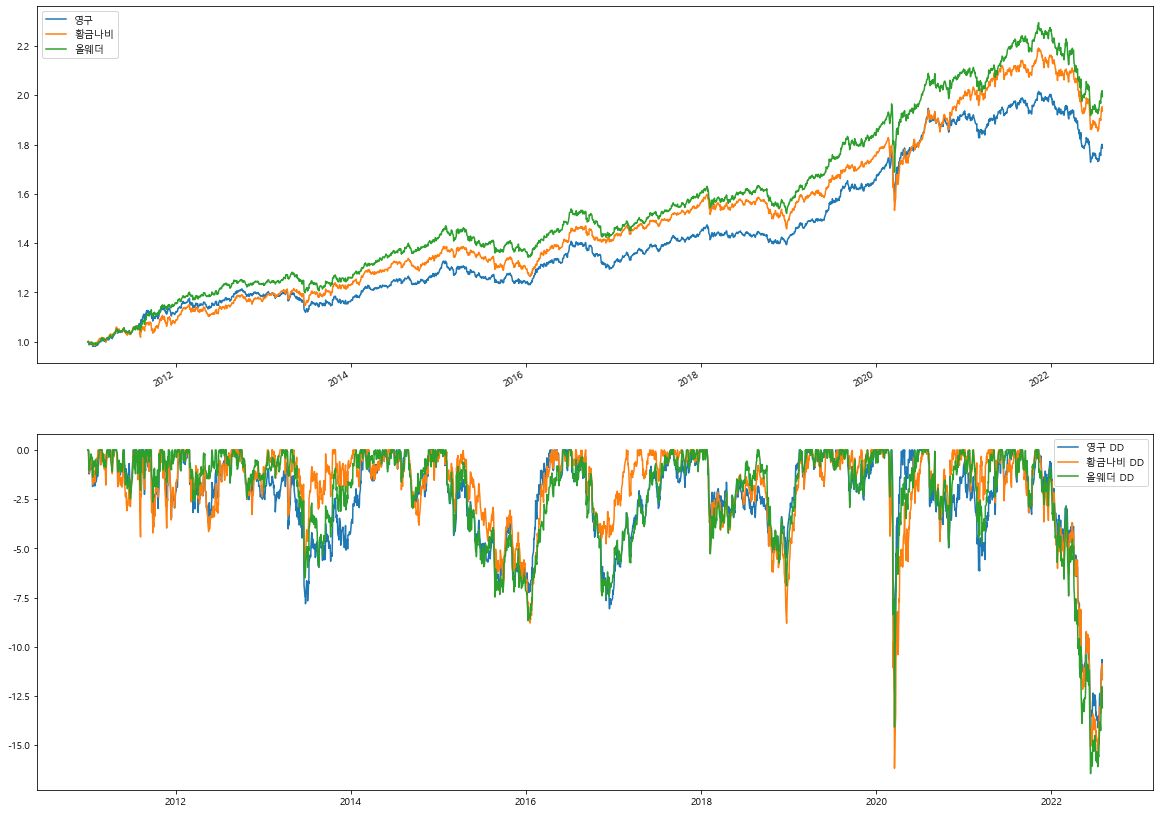

In [14]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
perCumReturn.plot(label="영구")
flyCumReturn.plot(label="황금나비")
allWeatherCumReturn.plot(label="올웨더")
# stockCumReturn.plot(label="시장")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-perDD, label="영구 DD")
plt.plot(-flyDD, label="황금나비 DD")
plt.plot(-allWeatherDD, label="올웨더 DD")
# plt.plot(-stockDD, label="시장 DD")
plt.legend()

plt.show()

* 정적자산배분 전략 종목에 평균모멘텀 스코어 전략을 적용하여, 동적 자산배분으로 만든다면 어떻게 될까?